give similar figures, but for namespace 0 only (chart of top reverts, self and non-self in dif colors, use dif colors, doesn’t like blue / red.)
3 histograms
* top reverters revs (count)
* top reverted revs (count)
* top pairs (count) -- same as what we have but in namespace 0


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime

In [4]:
df = pd.read_csv('revs_scored_jan.tsv', sep='\t', header=0)

In [5]:
days = df.rev_timestamp.map(lambda ts: datetime.utcfromtimestamp(ts).day)
df['day'] = days

In [6]:
# isolate data to only data from Jan1-Jan21, reverted w/in 24 hours, revisions by a bot

sdf = df[df.day<22]
sdf_reverted = sdf[sdf.is_reverted] # w/o, still include 'none'
sdf_reverted_in_day = sdf_reverted[sdf_reverted.seconds_to_revert.astype('str').astype('int')<86400]
sdf_bots = sdf_reverted_in_day[sdf_reverted_in_day.user_is_bot]

In [7]:
# isolate namespace 0

namespace0 = sdf_bots[sdf_bots.page_namespace == 0]

In [8]:
# to do next: find matching rev_id to revert_ids of where user_is_bot is true?
sdf_another = df[df.user_is_bot]
sdf_another = sdf_another[sdf_another.is_revert]

sdf1 = namespace0.loc[namespace0.is_reverted, ["rev_id", "user_text", "revert_id"]]
sdf1.revert_id = sdf1.revert_id.astype('int')

sdf2 = sdf_another[["rev_id", 'user_text', "is_self_revert"]]

In [9]:
# subset bot-bot reverts using merge

bot_bot_reverts = pd.merge(sdf1, sdf2, 
             how='inner', 
             left_on='revert_id', 
             right_on='rev_id', 
             suffixes=('', '_reverter')
)

In [10]:
bot_pairs = bot_bot_reverts.groupby(["user_text","user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [11]:
bot_pairs

,index,user_text,user_text_reverter,rev_id,revert_id,rev_id_reverter,is_self_revert
0,3,EmausBot,EmausBot,294,294,294,294
1,6,RMCD bot,RMCD bot,47,47,47,47
2,2,DPL bot,DPL bot,17,17,17,17
3,4,Filedelinkerbot,Filedelinkerbot,8,8,8,8
4,1,Cyberbot II,Cyberbot II,6,6,6,6
5,7,RonBot,RonBot,2,2,2,2
6,0,ClueBot NG,EmausBot,1,1,1,1
7,5,JCW-CleanerBot,JCW-CleanerBot,1,1,1,1


In [12]:
bot_bot_reverts.groupby(["user_text","user_text_reverter"], as_index = False).sum().sort_values("rev_id", ascending=False).reset_index()

,index,user_text,user_text_reverter,rev_id,revert_id,rev_id_reverter,is_self_revert
0,3,EmausBot,EmausBot,258015404640,258024564260,258024564260,290
1,6,RMCD bot,RMCD bot,41272626516,41273464584,41273464584,44
2,2,DPL bot,DPL bot,14922002776,14924556522,14924556522,17
3,4,Filedelinkerbot,Filedelinkerbot,7027773933,7027774401,7027774401,0
4,1,Cyberbot II,Cyberbot II,5271125803,5271668151,5271668151,6
5,7,RonBot,RonBot,1752468744,1752586514,1752586514,2
6,0,ClueBot NG,EmausBot,878888255,878888657,878888657,0
7,5,JCW-CleanerBot,JCW-CleanerBot,878794664,878794769,878794769,1


note: why does is_self_revert column not match up with totals in above chart? shouldn't all counted things be self-reverts if user_text and user_text_reverter match up?

In [26]:
bot_bot_reverts[(bot_bot_reverts.user_text == "EmausBot") & (bot_bot_reverts.user_text_reverter == "EmausBot") & (bot_bot_reverts.is_self_revert == False)]

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
98,877003459,EmausBot,877006852,877006852,EmausBot,False
299,878468083,EmausBot,878538474,878538474,EmausBot,False
324,878842220,EmausBot,878983569,878983569,EmausBot,False
325,878842233,EmausBot,878983590,878983590,EmausBot,False


depends on how is_self_revert is computed

if there is an intervening edit by another user, doesn't count as a self revert (in our current data)

In [14]:
bot_pairs

bot_pairs["category_is_self_revert"] = False

for row in bot_pairs.itertuples():
    if row.user_text_reverter == row.user_text:
        bot_pairs.loc[row.Index, "category_is_self_revert"] = True

In [15]:
bot_pairs

,index,user_text,user_text_reverter,rev_id,revert_id,rev_id_reverter,is_self_revert,category_is_self_revert
0,3,EmausBot,EmausBot,294,294,294,294,True
1,6,RMCD bot,RMCD bot,47,47,47,47,True
2,2,DPL bot,DPL bot,17,17,17,17,True
3,4,Filedelinkerbot,Filedelinkerbot,8,8,8,8,True
4,1,Cyberbot II,Cyberbot II,6,6,6,6,True
5,7,RonBot,RonBot,2,2,2,2,True
6,0,ClueBot NG,EmausBot,1,1,1,1,False
7,5,JCW-CleanerBot,JCW-CleanerBot,1,1,1,1,True


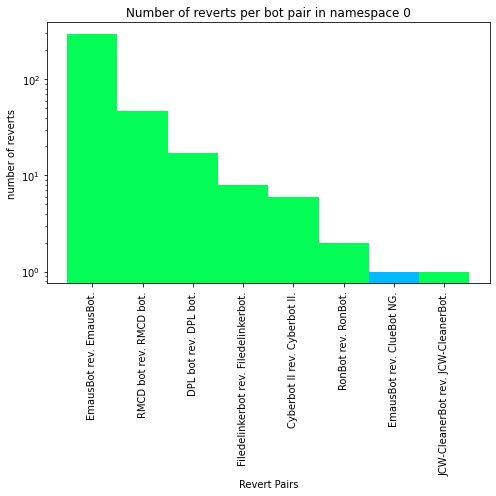

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

y = range(len(bot_pairs))

map = bot_pairs.category_is_self_revert.map(lambda is_self: '#03fc56' if is_self else '#03bafc')

axes.bar(y, bot_pairs.rev_id, width=1, color = map)

axes.set_title("Number of reverts per bot pair in namespace 0")
axes.set_xlabel("Revert Pairs")
axes.set_ylabel("number of reverts")

axes.set_yscale('log')

axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text_reverter} rev. {row.user_text}." for row in bot_pairs.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()

In [17]:
top_reverted_bots = bot_bot_reverts.groupby(["user_text"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [18]:
top_reverted_bots

,index,user_text,rev_id,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
0,3,EmausBot,294,294,294,294,294
1,6,RMCD bot,47,47,47,47,47
2,2,DPL bot,17,17,17,17,17
3,4,Filedelinkerbot,8,8,8,8,8
4,1,Cyberbot II,6,6,6,6,6
5,7,RonBot,2,2,2,2,2
6,0,ClueBot NG,1,1,1,1,1
7,5,JCW-CleanerBot,1,1,1,1,1


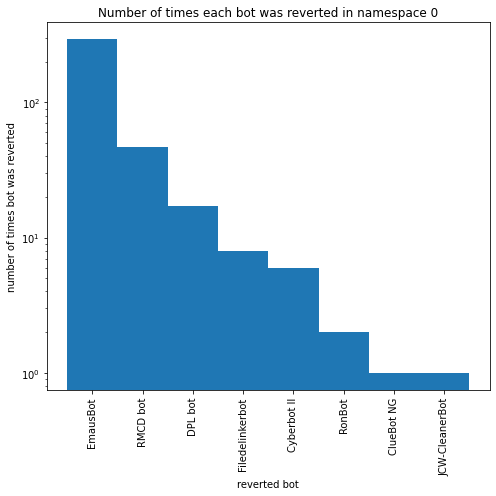

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

y = range(len(top_reverted_bots))

axes.bar(y, top_reverted_bots.rev_id, width=1)

axes.set_title("Number of times each bot was reverted in namespace 0")
axes.set_xlabel("reverted bot")
axes.set_ylabel("number of times bot was reverted")

axes.set_yscale('log')

axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text}" for row in top_reverted_bots.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()

In [20]:
top_reverter_bots = bot_bot_reverts.groupby(["user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [21]:
top_reverter_bots

,index,user_text_reverter,rev_id,user_text,revert_id,rev_id_reverter,is_self_revert
0,2,EmausBot,295,295,295,295,295
1,5,RMCD bot,47,47,47,47,47
2,1,DPL bot,17,17,17,17,17
3,3,Filedelinkerbot,8,8,8,8,8
4,0,Cyberbot II,6,6,6,6,6
5,6,RonBot,2,2,2,2,2
6,4,JCW-CleanerBot,1,1,1,1,1


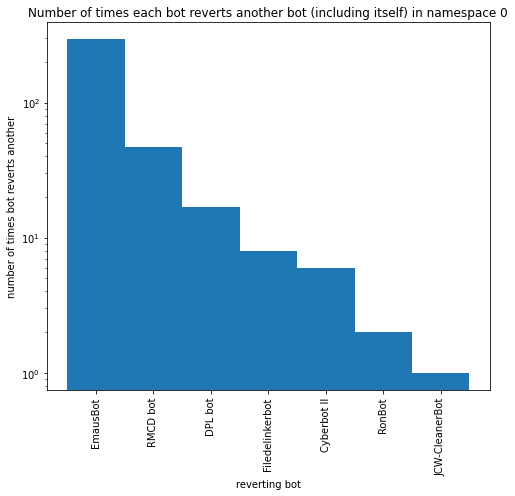

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

y = range(len(top_reverter_bots))

axes.bar(y, top_reverter_bots.rev_id, width=1)

axes.set_title("Number of times each bot reverts another bot (including itself) in namespace 0")
axes.set_xlabel("reverting bot")
axes.set_ylabel("number of times bot reverts another")

axes.set_yscale('log')

axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text_reverter}" for row in top_reverter_bots.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()